In [669]:
import numpy as np
import pandas as pd
import os
#import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from scipy import sparse as sps
from sklearn.metrics import mean_squared_error
from ast import literal_eval
from scipy.sparse.linalg import svds
import statistics
from math import sqrt
from scipy import sparse

### Ucitavanje podataka ratings.csv

In [670]:
data_path = 'datasets/'
ratings_filename = 'ratings.csv'

ratings_df = pd.read_csv(os.path.join(data_path, ratings_filename), usecols=['userId', 'movieId', 'rating'], dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})
ratings_df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


### Kreiranje matrice [broj_korisnika x broj_filmova]
Potrebno je napraviti matricu svih korisnika i svih filmova, odnosno matricu dimenzija broj_korisnika x broj_filmova. Ova matrica se moze napraviti uz pomoc funkcije pivot koja se poziva nad DataFrame-om.

In [671]:
ratings_pivot_df = ratings_df.pivot(index='userId',columns='movieId',values='rating')
ratings_pivot_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Nedostajuci podaci koji se javljaju prilikom ovog procesa trebaju biti zamenjeni nulama, kako bi nadalje nad njima mogla da se vrse potrebna izracunavanja.

In [672]:
pivot_ratings = ratings_pivot_df.fillna(0)
pivot_ratings.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Provera dimenzije matrice, odnosno broja jedinstvenih korisnika i jedinstvenih filmova. Prema podacima iz sveske Data_analysis u kojoj su ovi podaci ispitani: "Postoji 610 jedinstvenih korisnika i 9724 jedinstvenih filmova u ovom skupu podataka.".

In [673]:
pivot_ratings.shape # poklapa se sa brojem jedinstvenih korisnika odnosno filmova

(610, 9724)

Matrica ratings_pivot je retka matrica, pa se moze iskoristiti funkcija csr_matrix iz scipy.sparse paketa, koja cuva informacije o matrici na specifican nacin. #TODO dopuniti

In [674]:
ratings_csr_matrix = sps.csr_matrix(pivot_ratings)
print(ratings_csr_matrix.todense()) #toarray returns an ndarray; todense returns a matrix.

[[4.  0.  4.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 ...
 [2.5 2.  2.  ... 0.  0.  0. ]
 [3.  0.  0.  ... 0.  0.  0. ]
 [5.  0.  0.  ... 0.  0.  0. ]]


In [212]:
ratings_csr_matrix.shape

(610, 9724)

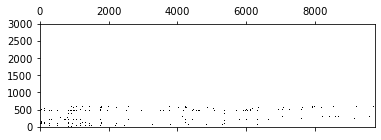

In [675]:
plt.spy(ratings_csr_matrix.toarray())
#plt.axis('equal')
plt.xlim(0, 9724)
plt.ylim(0, 3000)
plt.show()

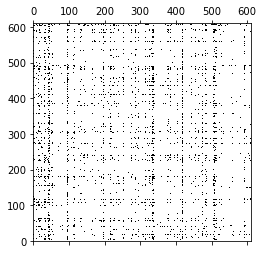

In [676]:
# posmatrano na manjem intervalu
plt.spy(ratings_csr_matrix.toarray())
plt.xlim(0, 610)
plt.ylim(0, 610)
plt.show()

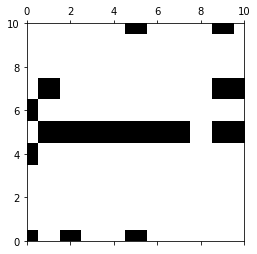

In [677]:
# posmatrano na jos manjem intervalu
plt.spy(ratings_csr_matrix.toarray())
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.show()

Naredna funkcija deli podatke na skup za treniranje i skup za testiranje u datoj razmeri. Napomena: matrice trebaju biti istih dimenzija, ali sa drugacije rasporedjenim ocenama.

In [678]:
# Podela datog skupa podataka na skup za trening i skup za test se u narednoj funkciji
# vrsi tako sto se iz datog skupa "uzima" percentage % ocena koje se upisuju u test skup,
# a uklanjaju iz trening skupa

# parametar ratings_csr_matrix je skup podataka koji treba podeliti na trening i test skup
# percentage je broj koji predstavlja procenat ocena koje ulaze u test skup

def split_train_test(ratings_csr_matrix, percentage):
    
    test_ratings_number = percentage / 100
    print("Odnos ocena u skupu za testiranje: ", percentage, "%")
    print("Odnos ocena u skupu za treniranje: ", 100-percentage, "%")

    total_ratings = ratings_csr_matrix.toarray()

    dimensions_of_total_ratings = total_ratings.shape
    print("Ukupan broj korisnika: ", dimensions_of_total_ratings[0])
    print("Ukupan broj filmova: ", dimensions_of_total_ratings[1])

    test = np.zeros(dimensions_of_total_ratings)
    train = total_ratings.copy()

    nonzero_ratings_per_row = (total_ratings != 0).sum(1)
    print("Ukupan broj ne-nula ocena u svim redovima: \n", nonzero_ratings_per_row)
    
    for user in range(dimensions_of_total_ratings[0]):
        
        nonzero_test_ratings_per_user = int(np.ceil(test_ratings_number*nonzero_ratings_per_row[user])) # ispod - indeksi ne-nula elemenata
        # print("Ukupan broj ne-nula ocena u test skupu po korisniku: ", nonzero_test_ratings_per_user)
        
        test_ratings = np.random.choice(total_ratings[user, :].nonzero()[0], size = nonzero_test_ratings_per_user, replace = False)

        train[user, test_ratings] = 0 # izbacuju se iz trening skupa (upisuju se nule na odabranim pozicijama)

        test[user, test_ratings] = total_ratings[user, test_ratings] # ubacuju se u test skup (upisuju se ocene iz polaznog skupa, koje su uklonjene iz trening skupa)
        
    if (not(np.all((train * test) == 0))):
        print("Greska!")
    else:    
        return sps.csr_matrix(train),sps.csr_matrix(test)

In [217]:
ratings_csr_reduced = ratings_csr_matrix[:50, :150]
ratings_csr_reduced.shape

(50, 150)

In [606]:
train_and_validation, test = split_train_test(ratings_csr_reduced, 20)

Odnos ocena u skupu za testiranje:  20 %
Odnos ocena u skupu za treniranje:  80 %
Ukupan broj korisnika:  50
Ukupan broj filmova:  150
Ukupan broj ne-nula ocena u svim redovima: 
 [11  0  1 12 10 72  5 13  1  0 10  2  1 12  5  3  7 16 32  7 10  1  6  4
  0  6  8 15  4  1  9 22 19  5  7  1  3 15  3 30  3 25 27 14 23 12  6  3
  1  4]


In [295]:
train_and_validation.shape, test.shape

((50, 150), (50, 150))

In [605]:
def sort_descending(li):
    # reverse (Optional) - If True, the sorted list is reversed (or sorted in descending order).
    # reverse = None (Sorts in Ascending order)
    # key is set to sort using second element of 
    # sublist lambda has been used
    li.sort(key = lambda x: x[0], reverse=True)
    return li

### User based

In [688]:
def user_based_ratings_prediction(u, i, users_similarity, ratings, k = 5):
    
    neighbors = []
    similarities = list(zip(users_similarity[u][:], range(users_similarity.shape[0])))  # broj korisnika

    similarities_sorted = sort_descending(similarities)
    
    # najslicnijih k
    for i in range(1, k + 1):
        neighbors.append(similarities_sorted[i][1])
    print ("neighbors: ", neighbors)

    rated_by_u = ratings[u].nonzero()[1]
    print("Ocenio korisnik u: ", rated_by_u)
    
    user_u_mean = 0
    arr = ratings[u, :].toarray()[0]
    user_u_mean = sum(arr)
        
    if len(rated_by_u) != 0:
        user_u_mean = user_u_mean / len(rated_by_u) # prosecna ocena u-tog korisnika
        
    numerator, denominator = 0.0, 0.0

    for v in neighbors:
        rated_by_v = ratings[v].nonzero()[1]
        user_v_mean = 0
        # user_v_mean = sum(ratings[v, :].toarray()[0])
            
        if len(rated_by_v) != 0:
            for i in rated_by_v:
                user_v_mean += ratings[v, i]
            
            user_v_mean = user_v_mean / len(rated_by_v)
      

        r_vi = ratings[v,i]
        numerator += users_similarity[u][v]*(r_vi - user_v_mean)
        denominator += users_similarity[u][v]
        
    return user_u_mean + numerator/denominator

### Item based

In [684]:
def item_based_ratings_prediction(u, i, movies_similarity, ratings, k):        
           
    neighbors = []
    similarities = list(zip(movies_similarity[i][:],range(movies_similarity.shape[0])))
    
    similarities_sorted = sort_descending(similarities)
    
    for i in range(1,k+1):
        neighbors.append(similarities_sorted[i][1])
        
    rated_i = ratings[:, i].nonzero()[0]
        
    item_i_mean = 0
    item_i_mean = sum(ratings[:, i].toarray()[0])
    
    if len(rated_i) != 0:
        item_i_mean = item_i_mean / len(rated_i)
        
    numerator, denominator = 0.0, 0.0
        
    for j in neighbors:
        rated_j = ratings[:, j].nonzero()[0]
        item_j_mean = 0
        
        if len(rated_j) != 0:
            arr2 = ratings[:, j].toarray()[0]
            item_j_mean = sum(arr2)
            item_j_mean = item_j_mean / len(rated_j)
        
        r_uj = ratings[u,j]
        numerator += movies_similarity[i][j]*(r_uj - item_j_mean)
        denominator += movies_similarity[i][j]
        
    return item_i_mean + numerator/denominator

In [660]:
def get_prediction(ratings, similarity_matrix, cf_type, k = 5):
    predictions = np.zeros(ratings.shape)
    
    if cf_type == 'user':
        for u in range(ratings.shape[0]):
            for i in range(ratings.shape[1]):
                predictions[u,i] = user_based_ratings_prediction(u, i, similarity_matrix , ratings, k)
    elif cf_type == 'item':
        for u in range(ratings.shape[0]):
            for i in range(ratings.shape[1]):
                predictions[u,i] = item_based_ratings_prediction(u, i, similarity_matrix, ratings, k)
    else:
        print("Greska! Tip mora biti user ili item.")
        return

    return predictions

### Item based

In [689]:
train, validation = split_train_test(train_and_validation, 20)
similarity = cosine_similarity(train.T) + 0.000000003

k=2
predictions2 = get_prediction(train, similarity, 'item', k)

Odnos ocena u skupu za testiranje:  20 %
Odnos ocena u skupu za treniranje:  80 %
Ukupan broj korisnika:  50
Ukupan broj filmova:  150
Ukupan broj ne-nula ocena u svim redovima: 
 [ 8  0  0  9  8 57  4 10  0  0  8  1  0  9  4  2  5 12 25  5  8  0  4  3
  0  4  6 12  3  0  7 17 15  4  5  0  2 12  2 24  2 20 21 11 18  9  4  2
  0  3]


In [690]:
predictions

array([[4.31125105, 4.31125105, 4.31125105, ..., 4.31125105, 4.31125105,
        4.31125105],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [3.33140208, 3.33140208, 3.33140208, ..., 3.33140208, 3.33140208,
        3.33140208],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [3.3918283 , 3.3918283 , 3.3918283 , ..., 3.3918283 , 3.3918283 ,
        3.3918283 ]])

### User based

In [691]:
train, validation = split_train_test(train_and_validation, 20)
similarity = cosine_similarity(train)+(0.000000000004)
k=2
predictions = get_prediction(train, similarity, 'user', k)

Odnos ocena u skupu za testiranje:  20 %
Odnos ocena u skupu za treniranje:  80 %
Ukupan broj korisnika:  50
Ukupan broj filmova:  150
Ukupan broj ne-nula ocena u svim redovima: 
 [ 8  0  0  9  8 57  4 10  0  0  8  1  0  9  4  2  5 12 25  5  8  0  4  3
  0  4  6 12  3  0  7 17 15  4  5  0  2 12  2 24  2 20 21 11 18  9  4  2
  0  3]
neighbors:  [17, 16]
Ocenio korisnik u:  [  0  43  89  97 130 136]
neighbors:  [17, 16]
Ocenio korisnik u:  [  0  43  89  97 130 136]
neighbors:  [17, 16]
Ocenio korisnik u:  [  0  43  89  97 130 136]
neighbors:  [17, 16]
Ocenio korisnik u:  [  0  43  89  97 130 136]
neighbors:  [17, 16]
Ocenio korisnik u:  [  0  43  89  97 130 136]
neighbors:  [17, 16]
Ocenio korisnik u:  [  0  43  89  97 130 136]
neighbors:  [17, 16]
Ocenio korisnik u:  [  0  43  89  97 130 136]
neighbors:  [17, 16]
Ocenio korisnik u:  [  0  43  89  97 130 136]
neighbors:  [17, 16]
Ocenio korisnik u:  [  0  43  89  97 130 136]
neighbors:  [17, 16]
Ocenio korisnik u:  [  0  43  89  97 130 1

Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors: 

Ocenio korisnik u:  [ 20  41  43  47  94 109 143]
neighbors:  [34, 4]
Ocenio korisnik u:  [ 20  41  43  47  94 109 143]
neighbors:  [34, 4]
Ocenio korisnik u:  [ 20  41  43  47  94 109 143]
neighbors:  [34, 4]
Ocenio korisnik u:  [ 20  41  43  47  94 109 143]
neighbors:  [34, 4]
Ocenio korisnik u:  [ 20  41  43  47  94 109 143]
neighbors:  [34, 4]
Ocenio korisnik u:  [ 20  41  43  47  94 109 143]
neighbors:  [34, 4]
Ocenio korisnik u:  [ 20  41  43  47  94 109 143]
neighbors:  [34, 4]
Ocenio korisnik u:  [ 20  41  43  47  94 109 143]
neighbors:  [34, 4]
Ocenio korisnik u:  [ 20  41  43  47  94 109 143]
neighbors:  [34, 4]
Ocenio korisnik u:  [ 20  41  43  47  94 109 143]
neighbors:  [34, 4]
Ocenio korisnik u:  [ 20  41  43  47  94 109 143]
neighbors:  [34, 4]
Ocenio korisnik u:  [ 20  41  43  47  94 109 143]
neighbors:  [34, 4]
Ocenio korisnik u:  [ 20  41  43  47  94 109 143]
neighbors:  [34, 4]
Ocenio korisnik u:  [ 20  41  43  47  94 109 143]
neighbors:  [34, 4]
Ocenio korisnik u:  

Ocenio korisnik u:  [ 0 20 35 46 52 97]
neighbors:  [37, 32]
Ocenio korisnik u:  [ 0 20 35 46 52 97]
neighbors:  [37, 32]
Ocenio korisnik u:  [ 0 20 35 46 52 97]
neighbors:  [37, 32]
Ocenio korisnik u:  [ 0 20 35 46 52 97]
neighbors:  [37, 32]
Ocenio korisnik u:  [ 0 20 35 46 52 97]
neighbors:  [37, 32]
Ocenio korisnik u:  [ 0 20 35 46 52 97]
neighbors:  [37, 32]
Ocenio korisnik u:  [ 0 20 35 46 52 97]
neighbors:  [37, 32]
Ocenio korisnik u:  [ 0 20 35 46 52 97]
neighbors:  [37, 32]
Ocenio korisnik u:  [ 0 20 35 46 52 97]
neighbors:  [37, 32]
Ocenio korisnik u:  [ 0 20 35 46 52 97]
neighbors:  [37, 32]
Ocenio korisnik u:  [ 0 20 35 46 52 97]
neighbors:  [37, 32]
Ocenio korisnik u:  [ 0 20 35 46 52 97]
neighbors:  [37, 32]
Ocenio korisnik u:  [ 0 20 35 46 52 97]
neighbors:  [37, 32]
Ocenio korisnik u:  [ 0 20 35 46 52 97]
neighbors:  [37, 32]
Ocenio korisnik u:  [ 0 20 35 46 52 97]
neighbors:  [37, 32]
Ocenio korisnik u:  [ 0 20 35 46 52 97]
neighbors:  [37, 32]
Ocenio korisnik u:  [ 0 

Ocenio korisnik u:  [ 0 20 35 46 52 97]
neighbors:  [37, 32]
Ocenio korisnik u:  [ 0 20 35 46 52 97]
neighbors:  [37, 32]
Ocenio korisnik u:  [ 0 20 35 46 52 97]
neighbors:  [37, 32]
Ocenio korisnik u:  [ 0 20 35 46 52 97]
neighbors:  [37, 32]
Ocenio korisnik u:  [ 0 20 35 46 52 97]
neighbors:  [37, 32]
Ocenio korisnik u:  [ 0 20 35 46 52 97]
neighbors:  [37, 32]
Ocenio korisnik u:  [ 0 20 35 46 52 97]
neighbors:  [37, 32]
Ocenio korisnik u:  [ 0 20 35 46 52 97]
neighbors:  [37, 32]
Ocenio korisnik u:  [ 0 20 35 46 52 97]
neighbors:  [37, 32]
Ocenio korisnik u:  [ 0 20 35 46 52 97]
neighbors:  [41, 43]
Ocenio korisnik u:  [  2   3   7  10  16  21  26  30  31  32  33  39  41  42  46  49  53  58
  59  68  71  78  79  80  82  84  88  90  92  97  99 100 109 113 115 116
 119 123 124 126 132 133 134 140 149]
neighbors:  [41, 43]
Ocenio korisnik u:  [  2   3   7  10  16  21  26  30  31  32  33  39  41  42  46  49  53  58
  59  68  71  78  79  80  82  84  88  90  92  97  99 100 109 113 115 116

neighbors:  [41, 43]
Ocenio korisnik u:  [  2   3   7  10  16  21  26  30  31  32  33  39  41  42  46  49  53  58
  59  68  71  78  79  80  82  84  88  90  92  97  99 100 109 113 115 116
 119 123 124 126 132 133 134 140 149]
neighbors:  [41, 43]
Ocenio korisnik u:  [  2   3   7  10  16  21  26  30  31  32  33  39  41  42  46  49  53  58
  59  68  71  78  79  80  82  84  88  90  92  97  99 100 109 113 115 116
 119 123 124 126 132 133 134 140 149]
neighbors:  [41, 43]
Ocenio korisnik u:  [  2   3   7  10  16  21  26  30  31  32  33  39  41  42  46  49  53  58
  59  68  71  78  79  80  82  84  88  90  92  97  99 100 109 113 115 116
 119 123 124 126 132 133 134 140 149]
neighbors:  [41, 43]
Ocenio korisnik u:  [  2   3   7  10  16  21  26  30  31  32  33  39  41  42  46  49  53  58
  59  68  71  78  79  80  82  84  88  90  92  97  99 100 109 113 115 116
 119 123 124 126 132 133 134 140 149]
neighbors:  [41, 43]
Ocenio korisnik u:  [  2   3   7  10  16  21  26  30  31  32  33  39  41  42  4

Ocenio korisnik u:  [  2   3   7  10  16  21  26  30  31  32  33  39  41  42  46  49  53  58
  59  68  71  78  79  80  82  84  88  90  92  97  99 100 109 113 115 116
 119 123 124 126 132 133 134 140 149]
neighbors:  [41, 43]
Ocenio korisnik u:  [  2   3   7  10  16  21  26  30  31  32  33  39  41  42  46  49  53  58
  59  68  71  78  79  80  82  84  88  90  92  97  99 100 109 113 115 116
 119 123 124 126 132 133 134 140 149]
neighbors:  [41, 43]
Ocenio korisnik u:  [  2   3   7  10  16  21  26  30  31  32  33  39  41  42  46  49  53  58
  59  68  71  78  79  80  82  84  88  90  92  97  99 100 109 113 115 116
 119 123 124 126 132 133 134 140 149]
neighbors:  [41, 43]
Ocenio korisnik u:  [  2   3   7  10  16  21  26  30  31  32  33  39  41  42  46  49  53  58
  59  68  71  78  79  80  82  84  88  90  92  97  99 100 109 113 115 116
 119 123 124 126 132 133 134 140 149]
neighbors:  [41, 43]
Ocenio korisnik u:  [  2   3   7  10  16  21  26  30  31  32  33  39  41  42  46  49  53  58
  59  6

Ocenio korisnik u:  [  0  46 138]
neighbors:  [45, 4]
Ocenio korisnik u:  [  0  46 138]
neighbors:  [45, 4]
Ocenio korisnik u:  [  0  46 138]
neighbors:  [45, 4]
Ocenio korisnik u:  [  0  46 138]
neighbors:  [45, 4]
Ocenio korisnik u:  [  0  46 138]
neighbors:  [45, 4]
Ocenio korisnik u:  [  0  46 138]
neighbors:  [45, 4]
Ocenio korisnik u:  [  0  46 138]
neighbors:  [45, 4]
Ocenio korisnik u:  [  0  46 138]
neighbors:  [45, 4]
Ocenio korisnik u:  [  0  46 138]
neighbors:  [45, 4]
Ocenio korisnik u:  [  0  46 138]
neighbors:  [45, 4]
Ocenio korisnik u:  [  0  46 138]
neighbors:  [45, 4]
Ocenio korisnik u:  [  0  46 138]
neighbors:  [45, 4]
Ocenio korisnik u:  [  0  46 138]
neighbors:  [45, 4]
Ocenio korisnik u:  [  0  46 138]
neighbors:  [45, 4]
Ocenio korisnik u:  [  0  46 138]
neighbors:  [45, 4]
Ocenio korisnik u:  [  0  46 138]
neighbors:  [45, 4]
Ocenio korisnik u:  [  0  46 138]
neighbors:  [45, 4]
Ocenio korisnik u:  [  0  46 138]
neighbors:  [45, 4]
Ocenio korisnik u:  [  0  46

neighbors:  [28, 25]
Ocenio korisnik u:  [  1   9  32  35  46 116 123 126]
neighbors:  [28, 25]
Ocenio korisnik u:  [  1   9  32  35  46 116 123 126]
neighbors:  [28, 25]
Ocenio korisnik u:  [  1   9  32  35  46 116 123 126]
neighbors:  [28, 25]
Ocenio korisnik u:  [  1   9  32  35  46 116 123 126]
neighbors:  [28, 25]
Ocenio korisnik u:  [  1   9  32  35  46 116 123 126]
neighbors:  [28, 25]
Ocenio korisnik u:  [  1   9  32  35  46 116 123 126]
neighbors:  [28, 25]
Ocenio korisnik u:  [  1   9  32  35  46 116 123 126]
neighbors:  [28, 25]
Ocenio korisnik u:  [  1   9  32  35  46 116 123 126]
neighbors:  [28, 25]
Ocenio korisnik u:  [  1   9  32  35  46 116 123 126]
neighbors:  [28, 25]
Ocenio korisnik u:  [  1   9  32  35  46 116 123 126]
neighbors:  [28, 25]
Ocenio korisnik u:  [  1   9  32  35  46 116 123 126]
neighbors:  [28, 25]
Ocenio korisnik u:  [  1   9  32  35  46 116 123 126]
neighbors:  [28, 25]
Ocenio korisnik u:  [  1   9  32  35  46 116 123 126]
neighbors:  [28, 25]
Ocen

neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik

neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik

neighbors:  [23, 37]
Ocenio korisnik u:  [  5  40  84  97 123 142]
neighbors:  [23, 37]
Ocenio korisnik u:  [  5  40  84  97 123 142]
neighbors:  [23, 37]
Ocenio korisnik u:  [  5  40  84  97 123 142]
neighbors:  [23, 37]
Ocenio korisnik u:  [  5  40  84  97 123 142]
neighbors:  [23, 37]
Ocenio korisnik u:  [  5  40  84  97 123 142]
neighbors:  [23, 37]
Ocenio korisnik u:  [  5  40  84  97 123 142]
neighbors:  [23, 37]
Ocenio korisnik u:  [  5  40  84  97 123 142]
neighbors:  [23, 37]
Ocenio korisnik u:  [  5  40  84  97 123 142]
neighbors:  [23, 37]
Ocenio korisnik u:  [  5  40  84  97 123 142]
neighbors:  [23, 37]
Ocenio korisnik u:  [  5  40  84  97 123 142]
neighbors:  [23, 37]
Ocenio korisnik u:  [  5  40  84  97 123 142]
neighbors:  [23, 37]
Ocenio korisnik u:  [  5  40  84  97 123 142]
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio ko

Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors: 

neighbors:  [46, 41]
Ocenio korisnik u:  [ 18  24  35  43  84  93 123]
neighbors:  [46, 41]
Ocenio korisnik u:  [ 18  24  35  43  84  93 123]
neighbors:  [46, 41]
Ocenio korisnik u:  [ 18  24  35  43  84  93 123]
neighbors:  [46, 41]
Ocenio korisnik u:  [ 18  24  35  43  84  93 123]
neighbors:  [46, 41]
Ocenio korisnik u:  [ 18  24  35  43  84  93 123]
neighbors:  [46, 41]
Ocenio korisnik u:  [ 18  24  35  43  84  93 123]
neighbors:  [46, 41]
Ocenio korisnik u:  [ 18  24  35  43  84  93 123]
neighbors:  [46, 41]
Ocenio korisnik u:  [ 18  24  35  43  84  93 123]
neighbors:  [46, 41]
Ocenio korisnik u:  [ 18  24  35  43  84  93 123]
neighbors:  [46, 41]
Ocenio korisnik u:  [ 18  24  35  43  84  93 123]
neighbors:  [46, 41]
Ocenio korisnik u:  [ 18  24  35  43  84  93 123]
neighbors:  [46, 41]
Ocenio korisnik u:  [ 18  24  35  43  84  93 123]
neighbors:  [46, 41]
Ocenio korisnik u:  [ 18  24  35  43  84  93 123]
neighbors:  [46, 41]
Ocenio korisnik u:  [ 18  24  35  43  84  93 123]
neighb

Ocenio korisnik u:  [ 40 131 144]
neighbors:  [47, 19]
Ocenio korisnik u:  [ 40 131 144]
neighbors:  [47, 19]
Ocenio korisnik u:  [ 40 131 144]
neighbors:  [47, 19]
Ocenio korisnik u:  [ 40 131 144]
neighbors:  [47, 19]
Ocenio korisnik u:  [ 40 131 144]
neighbors:  [47, 19]
Ocenio korisnik u:  [ 40 131 144]
neighbors:  [47, 19]
Ocenio korisnik u:  [ 40 131 144]
neighbors:  [47, 19]
Ocenio korisnik u:  [ 40 131 144]
neighbors:  [47, 19]
Ocenio korisnik u:  [ 40 131 144]
neighbors:  [47, 19]
Ocenio korisnik u:  [ 40 131 144]
neighbors:  [47, 19]
Ocenio korisnik u:  [ 40 131 144]
neighbors:  [47, 19]
Ocenio korisnik u:  [ 40 131 144]
neighbors:  [47, 19]
Ocenio korisnik u:  [ 40 131 144]
neighbors:  [47, 19]
Ocenio korisnik u:  [ 40 131 144]
neighbors:  [47, 19]
Ocenio korisnik u:  [ 40 131 144]
neighbors:  [47, 19]
Ocenio korisnik u:  [ 40 131 144]
neighbors:  [47, 19]
Ocenio korisnik u:  [ 40 131 144]
neighbors:  [47, 19]
Ocenio korisnik u:  [ 40 131 144]
neighbors:  [47, 19]
Ocenio kor

neighbors:  [41, 37]
Ocenio korisnik u:  [40 43 46 97]
neighbors:  [41, 37]
Ocenio korisnik u:  [40 43 46 97]
neighbors:  [41, 37]
Ocenio korisnik u:  [40 43 46 97]
neighbors:  [41, 37]
Ocenio korisnik u:  [40 43 46 97]
neighbors:  [41, 37]
Ocenio korisnik u:  [40 43 46 97]
neighbors:  [41, 37]
Ocenio korisnik u:  [40 43 46 97]
neighbors:  [41, 37]
Ocenio korisnik u:  [40 43 46 97]
neighbors:  [41, 37]
Ocenio korisnik u:  [40 43 46 97]
neighbors:  [41, 37]
Ocenio korisnik u:  [40 43 46 97]
neighbors:  [41, 37]
Ocenio korisnik u:  [40 43 46 97]
neighbors:  [41, 37]
Ocenio korisnik u:  [40 43 46 97]
neighbors:  [41, 37]
Ocenio korisnik u:  [40 43 46 97]
neighbors:  [41, 37]
Ocenio korisnik u:  [40 43 46 97]
neighbors:  [41, 37]
Ocenio korisnik u:  [40 43 46 97]
neighbors:  [41, 37]
Ocenio korisnik u:  [40 43 46 97]
neighbors:  [41, 37]
Ocenio korisnik u:  [40 43 46 97]
neighbors:  [41, 37]
Ocenio korisnik u:  [40 43 46 97]
neighbors:  [41, 37]
Ocenio korisnik u:  [40 43 46 97]
neighbors:

neighbors:  [0, 18]
Ocenio korisnik u:  [  0   1  15  31  32  43  97 136 138]
neighbors:  [0, 18]
Ocenio korisnik u:  [  0   1  15  31  32  43  97 136 138]
neighbors:  [0, 18]
Ocenio korisnik u:  [  0   1  15  31  32  43  97 136 138]
neighbors:  [0, 18]
Ocenio korisnik u:  [  0   1  15  31  32  43  97 136 138]
neighbors:  [0, 18]
Ocenio korisnik u:  [  0   1  15  31  32  43  97 136 138]
neighbors:  [0, 18]
Ocenio korisnik u:  [  0   1  15  31  32  43  97 136 138]
neighbors:  [0, 18]
Ocenio korisnik u:  [  0   1  15  31  32  43  97 136 138]
neighbors:  [0, 18]
Ocenio korisnik u:  [  0   1  15  31  32  43  97 136 138]
neighbors:  [0, 18]
Ocenio korisnik u:  [  0   1  15  31  32  43  97 136 138]
neighbors:  [0, 18]
Ocenio korisnik u:  [  0   1  15  31  32  43  97 136 138]
neighbors:  [0, 18]
Ocenio korisnik u:  [  0   1  15  31  32  43  97 136 138]
neighbors:  [0, 18]
Ocenio korisnik u:  [  0   1  15  31  32  43  97 136 138]
neighbors:  [0, 18]
Ocenio korisnik u:  [  0   1  15  31  32  43

neighbors:  [17, 25]
Ocenio korisnik u:  [  0   1   9  11  18  31  32  40  43  44  57  58  62  78  92  95 116 126
 134 142]
neighbors:  [17, 25]
Ocenio korisnik u:  [  0   1   9  11  18  31  32  40  43  44  57  58  62  78  92  95 116 126
 134 142]
neighbors:  [17, 25]
Ocenio korisnik u:  [  0   1   9  11  18  31  32  40  43  44  57  58  62  78  92  95 116 126
 134 142]
neighbors:  [17, 25]
Ocenio korisnik u:  [  0   1   9  11  18  31  32  40  43  44  57  58  62  78  92  95 116 126
 134 142]
neighbors:  [17, 25]
Ocenio korisnik u:  [  0   1   9  11  18  31  32  40  43  44  57  58  62  78  92  95 116 126
 134 142]
neighbors:  [17, 25]
Ocenio korisnik u:  [  0   1   9  11  18  31  32  40  43  44  57  58  62  78  92  95 116 126
 134 142]
neighbors:  [17, 25]
Ocenio korisnik u:  [  0   1   9  11  18  31  32  40  43  44  57  58  62  78  92  95 116 126
 134 142]
neighbors:  [17, 25]
Ocenio korisnik u:  [  0   1   9  11  18  31  32  40  43  44  57  58  62  78  92  95 116 126
 134 142]
neighbor

Ocenio korisnik u:  [  0   1   9  11  18  31  32  40  43  44  57  58  62  78  92  95 116 126
 134 142]
neighbors:  [17, 25]
Ocenio korisnik u:  [  0   1   9  11  18  31  32  40  43  44  57  58  62  78  92  95 116 126
 134 142]
neighbors:  [17, 25]
Ocenio korisnik u:  [  0   1   9  11  18  31  32  40  43  44  57  58  62  78  92  95 116 126
 134 142]
neighbors:  [17, 25]
Ocenio korisnik u:  [  0   1   9  11  18  31  32  40  43  44  57  58  62  78  92  95 116 126
 134 142]
neighbors:  [17, 25]
Ocenio korisnik u:  [  0   1   9  11  18  31  32  40  43  44  57  58  62  78  92  95 116 126
 134 142]
neighbors:  [17, 25]
Ocenio korisnik u:  [  0   1   9  11  18  31  32  40  43  44  57  58  62  78  92  95 116 126
 134 142]
neighbors:  [17, 25]
Ocenio korisnik u:  [  0   1   9  11  18  31  32  40  43  44  57  58  62  78  92  95 116 126
 134 142]
neighbors:  [17, 25]
Ocenio korisnik u:  [  0   1   9  11  18  31  32  40  43  44  57  58  62  78  92  95 116 126
 134 142]
neighbors:  [17, 25]
Ocenio k

neighbors:  [14, 18]
Ocenio korisnik u:  [  1   7  95 131]
neighbors:  [14, 18]
Ocenio korisnik u:  [  1   7  95 131]
neighbors:  [14, 18]
Ocenio korisnik u:  [  1   7  95 131]
neighbors:  [14, 18]
Ocenio korisnik u:  [  1   7  95 131]
neighbors:  [14, 18]
Ocenio korisnik u:  [  1   7  95 131]
neighbors:  [14, 18]
Ocenio korisnik u:  [  1   7  95 131]
neighbors:  [14, 18]
Ocenio korisnik u:  [  1   7  95 131]
neighbors:  [14, 18]
Ocenio korisnik u:  [  1   7  95 131]
neighbors:  [14, 18]
Ocenio korisnik u:  [  1   7  95 131]
neighbors:  [14, 18]
Ocenio korisnik u:  [  1   7  95 131]
neighbors:  [14, 18]
Ocenio korisnik u:  [  1   7  95 131]
neighbors:  [14, 18]
Ocenio korisnik u:  [  1   7  95 131]
neighbors:  [14, 18]
Ocenio korisnik u:  [  1   7  95 131]
neighbors:  [14, 18]
Ocenio korisnik u:  [  1   7  95 131]
neighbors:  [14, 18]
Ocenio korisnik u:  [  1   7  95 131]
neighbors:  [14, 18]
Ocenio korisnik u:  [  1   7  95 131]
neighbors:  [14, 18]
Ocenio korisnik u:  [  1   7  95 13

neighbors:  [26, 18]
Ocenio korisnik u:  [  0  18  34  44 118 142]
neighbors:  [26, 18]
Ocenio korisnik u:  [  0  18  34  44 118 142]
neighbors:  [26, 18]
Ocenio korisnik u:  [  0  18  34  44 118 142]
neighbors:  [26, 18]
Ocenio korisnik u:  [  0  18  34  44 118 142]
neighbors:  [26, 18]
Ocenio korisnik u:  [  0  18  34  44 118 142]
neighbors:  [26, 18]
Ocenio korisnik u:  [  0  18  34  44 118 142]
neighbors:  [26, 18]
Ocenio korisnik u:  [  0  18  34  44 118 142]
neighbors:  [26, 18]
Ocenio korisnik u:  [  0  18  34  44 118 142]
neighbors:  [26, 18]
Ocenio korisnik u:  [  0  18  34  44 118 142]
neighbors:  [26, 18]
Ocenio korisnik u:  [  0  18  34  44 118 142]
neighbors:  [26, 18]
Ocenio korisnik u:  [  0  18  34  44 118 142]
neighbors:  [26, 18]
Ocenio korisnik u:  [  0  18  34  44 118 142]
neighbors:  [26, 18]
Ocenio korisnik u:  [  0  18  34  44 118 142]
neighbors:  [26, 18]
Ocenio korisnik u:  [  0  18  34  44 118 142]
neighbors:  [26, 18]
Ocenio korisnik u:  [  0  18  34  44 118 

neighbors:  [23, 38]
Ocenio korisnik u:  [ 5 31 52]
neighbors:  [23, 38]
Ocenio korisnik u:  [ 5 31 52]
neighbors:  [23, 38]
Ocenio korisnik u:  [ 5 31 52]
neighbors:  [23, 38]
Ocenio korisnik u:  [ 5 31 52]
neighbors:  [23, 38]
Ocenio korisnik u:  [ 5 31 52]
neighbors:  [23, 38]
Ocenio korisnik u:  [ 5 31 52]
neighbors:  [23, 38]
Ocenio korisnik u:  [ 5 31 52]
neighbors:  [23, 38]
Ocenio korisnik u:  [ 5 31 52]
neighbors:  [23, 38]
Ocenio korisnik u:  [ 5 31 52]
neighbors:  [23, 38]
Ocenio korisnik u:  [ 5 31 52]
neighbors:  [23, 38]
Ocenio korisnik u:  [ 5 31 52]
neighbors:  [23, 38]
Ocenio korisnik u:  [ 5 31 52]
neighbors:  [23, 38]
Ocenio korisnik u:  [ 5 31 52]
neighbors:  [23, 38]
Ocenio korisnik u:  [ 5 31 52]
neighbors:  [23, 38]
Ocenio korisnik u:  [ 5 31 52]
neighbors:  [23, 38]
Ocenio korisnik u:  [ 5 31 52]
neighbors:  [23, 38]
Ocenio korisnik u:  [ 5 31 52]
neighbors:  [23, 38]
Ocenio korisnik u:  [ 5 31 52]
neighbors:  [23, 38]
Ocenio korisnik u:  [ 5 31 52]
neighbors:  

neighbors:  [22, 38]
Ocenio korisnik u:  [ 5 31]
neighbors:  [22, 38]
Ocenio korisnik u:  [ 5 31]
neighbors:  [22, 38]
Ocenio korisnik u:  [ 5 31]
neighbors:  [22, 38]
Ocenio korisnik u:  [ 5 31]
neighbors:  [22, 38]
Ocenio korisnik u:  [ 5 31]
neighbors:  [22, 38]
Ocenio korisnik u:  [ 5 31]
neighbors:  [22, 38]
Ocenio korisnik u:  [ 5 31]
neighbors:  [22, 38]
Ocenio korisnik u:  [ 5 31]
neighbors:  [22, 38]
Ocenio korisnik u:  [ 5 31]
neighbors:  [22, 38]
Ocenio korisnik u:  [ 5 31]
neighbors:  [22, 38]
Ocenio korisnik u:  [ 5 31]
neighbors:  [22, 38]
Ocenio korisnik u:  [ 5 31]
neighbors:  [22, 38]
Ocenio korisnik u:  [ 5 31]
neighbors:  [22, 38]
Ocenio korisnik u:  [ 5 31]
neighbors:  [22, 38]
Ocenio korisnik u:  [ 5 31]
neighbors:  [22, 38]
Ocenio korisnik u:  [ 5 31]
neighbors:  [22, 38]
Ocenio korisnik u:  [ 5 31]
neighbors:  [22, 38]
Ocenio korisnik u:  [ 5 31]
neighbors:  [22, 38]
Ocenio korisnik u:  [ 5 31]
neighbors:  [22, 38]
Ocenio korisnik u:  [ 5 31]
neighbors:  [22, 38]

neighbors:  [36, 7]
Ocenio korisnik u:  [  9  32 126]
neighbors:  [36, 7]
Ocenio korisnik u:  [  9  32 126]
neighbors:  [36, 7]
Ocenio korisnik u:  [  9  32 126]
neighbors:  [36, 7]
Ocenio korisnik u:  [  9  32 126]
neighbors:  [36, 7]
Ocenio korisnik u:  [  9  32 126]
neighbors:  [36, 7]
Ocenio korisnik u:  [  9  32 126]
neighbors:  [36, 7]
Ocenio korisnik u:  [  9  32 126]
neighbors:  [36, 7]
Ocenio korisnik u:  [  9  32 126]
neighbors:  [36, 7]
Ocenio korisnik u:  [  9  32 126]
neighbors:  [36, 7]
Ocenio korisnik u:  [  9  32 126]
neighbors:  [36, 7]
Ocenio korisnik u:  [  9  32 126]
neighbors:  [36, 7]
Ocenio korisnik u:  [  9  32 126]
neighbors:  [36, 7]
Ocenio korisnik u:  [  9  32 126]
neighbors:  [36, 7]
Ocenio korisnik u:  [  9  32 126]
neighbors:  [36, 7]
Ocenio korisnik u:  [  9  32 126]
neighbors:  [36, 7]
Ocenio korisnik u:  [  9  32 126]
neighbors:  [36, 7]
Ocenio korisnik u:  [  9  32 126]
neighbors:  [36, 7]
Ocenio korisnik u:  [  9  32 126]
neighbors:  [36, 7]
Ocenio k

Ocenio korisnik u:  [  0  44  53 109]
neighbors:  [20, 49]
Ocenio korisnik u:  [  0  44  53 109]
neighbors:  [20, 49]
Ocenio korisnik u:  [  0  44  53 109]
neighbors:  [20, 49]
Ocenio korisnik u:  [  0  44  53 109]
neighbors:  [20, 49]
Ocenio korisnik u:  [  0  44  53 109]
neighbors:  [20, 49]
Ocenio korisnik u:  [  0  44  53 109]
neighbors:  [20, 49]
Ocenio korisnik u:  [  0  44  53 109]
neighbors:  [20, 49]
Ocenio korisnik u:  [  0  44  53 109]
neighbors:  [20, 49]
Ocenio korisnik u:  [  0  44  53 109]
neighbors:  [20, 49]
Ocenio korisnik u:  [  0  44  53 109]
neighbors:  [20, 49]
Ocenio korisnik u:  [  0  44  53 109]
neighbors:  [20, 49]
Ocenio korisnik u:  [  0  44  53 109]
neighbors:  [20, 49]
Ocenio korisnik u:  [  0  44  53 109]
neighbors:  [20, 49]
Ocenio korisnik u:  [  0  44  53 109]
neighbors:  [20, 49]
Ocenio korisnik u:  [  0  44  53 109]
neighbors:  [20, 49]
Ocenio korisnik u:  [  0  44  53 109]
neighbors:  [20, 49]
Ocenio korisnik u:  [  0  44  53 109]
neighbors:  [20, 4

Ocenio korisnik u:  [ 15  22  30  31  46  55  97 120 144]
neighbors:  [37, 16]
Ocenio korisnik u:  [ 15  22  30  31  46  55  97 120 144]
neighbors:  [37, 16]
Ocenio korisnik u:  [ 15  22  30  31  46  55  97 120 144]
neighbors:  [37, 16]
Ocenio korisnik u:  [ 15  22  30  31  46  55  97 120 144]
neighbors:  [37, 16]
Ocenio korisnik u:  [ 15  22  30  31  46  55  97 120 144]
neighbors:  [37, 16]
Ocenio korisnik u:  [ 15  22  30  31  46  55  97 120 144]
neighbors:  [37, 16]
Ocenio korisnik u:  [ 15  22  30  31  46  55  97 120 144]
neighbors:  [37, 16]
Ocenio korisnik u:  [ 15  22  30  31  46  55  97 120 144]
neighbors:  [37, 16]
Ocenio korisnik u:  [ 15  22  30  31  46  55  97 120 144]
neighbors:  [37, 16]
Ocenio korisnik u:  [ 15  22  30  31  46  55  97 120 144]
neighbors:  [37, 16]
Ocenio korisnik u:  [ 15  22  30  31  46  55  97 120 144]
neighbors:  [37, 16]
Ocenio korisnik u:  [ 15  22  30  31  46  55  97 120 144]
neighbors:  [37, 16]
Ocenio korisnik u:  [ 15  22  30  31  46  55  97 120

neighbors:  [34, 7]
Ocenio korisnik u:  [ 46 123]
neighbors:  [34, 7]
Ocenio korisnik u:  [ 46 123]
neighbors:  [34, 7]
Ocenio korisnik u:  [ 46 123]
neighbors:  [34, 7]
Ocenio korisnik u:  [ 46 123]
neighbors:  [34, 7]
Ocenio korisnik u:  [ 46 123]
neighbors:  [34, 7]
Ocenio korisnik u:  [ 46 123]
neighbors:  [34, 7]
Ocenio korisnik u:  [ 46 123]
neighbors:  [34, 7]
Ocenio korisnik u:  [ 46 123]
neighbors:  [34, 7]
Ocenio korisnik u:  [ 46 123]
neighbors:  [34, 7]
Ocenio korisnik u:  [ 46 123]
neighbors:  [34, 7]
Ocenio korisnik u:  [ 46 123]
neighbors:  [34, 7]
Ocenio korisnik u:  [ 46 123]
neighbors:  [34, 7]
Ocenio korisnik u:  [ 46 123]
neighbors:  [34, 7]
Ocenio korisnik u:  [ 46 123]
neighbors:  [34, 7]
Ocenio korisnik u:  [ 46 123]
neighbors:  [34, 7]
Ocenio korisnik u:  [ 46 123]
neighbors:  [34, 7]
Ocenio korisnik u:  [ 46 123]
neighbors:  [34, 7]
Ocenio korisnik u:  [ 46 123]
neighbors:  [34, 7]
Ocenio korisnik u:  [ 46 123]
neighbors:  [34, 7]
Ocenio korisnik u:  [ 46 123]


neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [31, 6]
Ocenio korisnik u:  [  4   6  55 116 138]
neighbors:  [31, 6]
Ocenio korisnik u:  [  4   6  55 116 138]
neighbors:  [31, 6]
Ocenio korisnik u:  [  4   6  55 116 138]
neighbors:  [31, 6]
Ocenio korisnik u:  [  4   6  55 116 138]
neighbors:  [31, 6]
Ocenio korisnik u:  [  4   6  55 116 138]
neighbors:  [31, 6]
Ocenio korisnik u:  [  4   6  55 116 138]
neighbors:  [31, 6]
Ocenio korisnik u:  [  4   6  55 116 138]
neighbors:  [31, 6]
Ocenio korisnik u:  [  4   6  55 116 138]
neighbors:  [31, 6]
Ocenio korisnik u:  [  4   6  55 116 138]
neighbors:  [31, 6]
Ocenio korisnik u:  [  4   6  55 116 138]
neighbors:  [31, 6]
Ocenio korisnik u:  [  4   6  55 116 138]
neighbors:  [31, 6]
Ocenio korisnik u:  [  4   6  55 116 138]
neighbors:  [31, 6]
Ocenio korisnik u:  [  4   6  55 116 138]
neighbors:  [31, 6]
Ocenio korisnik u:  [  4   6  55 116 138]
neighb

neighbors:  [31, 6]
Ocenio korisnik u:  [  4   6  55 116 138]
neighbors:  [31, 6]
Ocenio korisnik u:  [  4   6  55 116 138]
neighbors:  [31, 6]
Ocenio korisnik u:  [  4   6  55 116 138]
neighbors:  [31, 6]
Ocenio korisnik u:  [  4   6  55 116 138]
neighbors:  [31, 6]
Ocenio korisnik u:  [  4   6  55 116 138]
neighbors:  [31, 6]
Ocenio korisnik u:  [  4   6  55 116 138]
neighbors:  [31, 6]
Ocenio korisnik u:  [  4   6  55 116 138]
neighbors:  [31, 6]
Ocenio korisnik u:  [  4   6  55 116 138]
neighbors:  [31, 6]
Ocenio korisnik u:  [  4   6  55 116 138]
neighbors:  [45, 23]
Ocenio korisnik u:  [  0   5  23  24  31  33  46  55  84  88 115 116 126]
neighbors:  [45, 23]
Ocenio korisnik u:  [  0   5  23  24  31  33  46  55  84  88 115 116 126]
neighbors:  [45, 23]
Ocenio korisnik u:  [  0   5  23  24  31  33  46  55  84  88 115 116 126]
neighbors:  [45, 23]
Ocenio korisnik u:  [  0   5  23  24  31  33  46  55  84  88 115 116 126]
neighbors:  [45, 23]
Ocenio korisnik u:  [  0   5  23  24  31 

Ocenio korisnik u:  [  0   5  23  24  31  33  46  55  84  88 115 116 126]
neighbors:  [45, 23]
Ocenio korisnik u:  [  0   5  23  24  31  33  46  55  84  88 115 116 126]
neighbors:  [45, 23]
Ocenio korisnik u:  [  0   5  23  24  31  33  46  55  84  88 115 116 126]
neighbors:  [45, 23]
Ocenio korisnik u:  [  0   5  23  24  31  33  46  55  84  88 115 116 126]
neighbors:  [45, 23]
Ocenio korisnik u:  [  0   5  23  24  31  33  46  55  84  88 115 116 126]
neighbors:  [45, 23]
Ocenio korisnik u:  [  0   5  23  24  31  33  46  55  84  88 115 116 126]
neighbors:  [45, 23]
Ocenio korisnik u:  [  0   5  23  24  31  33  46  55  84  88 115 116 126]
neighbors:  [45, 23]
Ocenio korisnik u:  [  0   5  23  24  31  33  46  55  84  88 115 116 126]
neighbors:  [45, 23]
Ocenio korisnik u:  [  0   5  23  24  31  33  46  55  84  88 115 116 126]
neighbors:  [45, 23]
Ocenio korisnik u:  [  0   5  23  24  31  33  46  55  84  88 115 116 126]
neighbors:  [45, 23]
Ocenio korisnik u:  [  0   5  23  24  31  33  46  

Ocenio korisnik u:  [  0   6  10  20  24  32  33  35  39  83  97 124]
neighbors:  [4, 37]
Ocenio korisnik u:  [  0   6  10  20  24  32  33  35  39  83  97 124]
neighbors:  [4, 37]
Ocenio korisnik u:  [  0   6  10  20  24  32  33  35  39  83  97 124]
neighbors:  [4, 37]
Ocenio korisnik u:  [  0   6  10  20  24  32  33  35  39  83  97 124]
neighbors:  [4, 37]
Ocenio korisnik u:  [  0   6  10  20  24  32  33  35  39  83  97 124]
neighbors:  [4, 37]
Ocenio korisnik u:  [  0   6  10  20  24  32  33  35  39  83  97 124]
neighbors:  [4, 37]
Ocenio korisnik u:  [  0   6  10  20  24  32  33  35  39  83  97 124]
neighbors:  [4, 37]
Ocenio korisnik u:  [  0   6  10  20  24  32  33  35  39  83  97 124]
neighbors:  [4, 37]
Ocenio korisnik u:  [  0   6  10  20  24  32  33  35  39  83  97 124]
neighbors:  [4, 37]
Ocenio korisnik u:  [  0   6  10  20  24  32  33  35  39  83  97 124]
neighbors:  [4, 37]
Ocenio korisnik u:  [  0   6  10  20  24  32  33  35  39  83  97 124]
neighbors:  [4, 37]
Ocenio kor

neighbors:  [0, 17]
Ocenio korisnik u:  [ 62  97 136]
neighbors:  [0, 17]
Ocenio korisnik u:  [ 62  97 136]
neighbors:  [0, 17]
Ocenio korisnik u:  [ 62  97 136]
neighbors:  [0, 17]
Ocenio korisnik u:  [ 62  97 136]
neighbors:  [0, 17]
Ocenio korisnik u:  [ 62  97 136]
neighbors:  [0, 17]
Ocenio korisnik u:  [ 62  97 136]
neighbors:  [0, 17]
Ocenio korisnik u:  [ 62  97 136]
neighbors:  [0, 17]
Ocenio korisnik u:  [ 62  97 136]
neighbors:  [0, 17]
Ocenio korisnik u:  [ 62  97 136]
neighbors:  [0, 17]
Ocenio korisnik u:  [ 62  97 136]
neighbors:  [0, 17]
Ocenio korisnik u:  [ 62  97 136]
neighbors:  [0, 17]
Ocenio korisnik u:  [ 62  97 136]
neighbors:  [0, 17]
Ocenio korisnik u:  [ 62  97 136]
neighbors:  [0, 17]
Ocenio korisnik u:  [ 62  97 136]
neighbors:  [0, 17]
Ocenio korisnik u:  [ 62  97 136]
neighbors:  [0, 17]
Ocenio korisnik u:  [ 62  97 136]
neighbors:  [0, 17]
Ocenio korisnik u:  [ 62  97 136]
neighbors:  [0, 17]
Ocenio korisnik u:  [ 62  97 136]
neighbors:  [0, 17]
Ocenio k

neighbors:  [28, 37]
Ocenio korisnik u:  [ 20  46  55 123]
neighbors:  [28, 37]
Ocenio korisnik u:  [ 20  46  55 123]
neighbors:  [28, 37]
Ocenio korisnik u:  [ 20  46  55 123]
neighbors:  [28, 37]
Ocenio korisnik u:  [ 20  46  55 123]
neighbors:  [28, 37]
Ocenio korisnik u:  [ 20  46  55 123]
neighbors:  [28, 37]
Ocenio korisnik u:  [ 20  46  55 123]
neighbors:  [28, 37]
Ocenio korisnik u:  [ 20  46  55 123]
neighbors:  [28, 37]
Ocenio korisnik u:  [ 20  46  55 123]
neighbors:  [28, 37]
Ocenio korisnik u:  [ 20  46  55 123]
neighbors:  [28, 37]
Ocenio korisnik u:  [ 20  46  55 123]
neighbors:  [28, 37]
Ocenio korisnik u:  [ 20  46  55 123]
neighbors:  [28, 37]
Ocenio korisnik u:  [ 20  46  55 123]
neighbors:  [28, 37]
Ocenio korisnik u:  [ 20  46  55 123]
neighbors:  [28, 37]
Ocenio korisnik u:  [ 20  46  55 123]
neighbors:  [28, 37]
Ocenio korisnik u:  [ 20  46  55 123]
neighbors:  [28, 37]
Ocenio korisnik u:  [ 20  46  55 123]
neighbors:  [28, 37]
Ocenio korisnik u:  [ 20  46  55 12

neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik

Ocenio korisnik u:  [126]
neighbors:  [25, 42]
Ocenio korisnik u:  [126]
neighbors:  [25, 42]
Ocenio korisnik u:  [126]
neighbors:  [25, 42]
Ocenio korisnik u:  [126]
neighbors:  [34, 28]
Ocenio korisnik u:  [ 20  35  44  46  55  97 123 124 134]
neighbors:  [34, 28]
Ocenio korisnik u:  [ 20  35  44  46  55  97 123 124 134]
neighbors:  [34, 28]
Ocenio korisnik u:  [ 20  35  44  46  55  97 123 124 134]
neighbors:  [34, 28]
Ocenio korisnik u:  [ 20  35  44  46  55  97 123 124 134]
neighbors:  [34, 28]
Ocenio korisnik u:  [ 20  35  44  46  55  97 123 124 134]
neighbors:  [34, 28]
Ocenio korisnik u:  [ 20  35  44  46  55  97 123 124 134]
neighbors:  [34, 28]
Ocenio korisnik u:  [ 20  35  44  46  55  97 123 124 134]
neighbors:  [34, 28]
Ocenio korisnik u:  [ 20  35  44  46  55  97 123 124 134]
neighbors:  [34, 28]
Ocenio korisnik u:  [ 20  35  44  46  55  97 123 124 134]
neighbors:  [34, 28]
Ocenio korisnik u:  [ 20  35  44  46  55  97 123 124 134]
neighbors:  [34, 28]
Ocenio korisnik u:  [ 

neighbors:  [34, 28]
Ocenio korisnik u:  [ 20  35  44  46  55  97 123 124 134]
neighbors:  [34, 28]
Ocenio korisnik u:  [ 20  35  44  46  55  97 123 124 134]
neighbors:  [34, 28]
Ocenio korisnik u:  [ 20  35  44  46  55  97 123 124 134]
neighbors:  [34, 28]
Ocenio korisnik u:  [ 20  35  44  46  55  97 123 124 134]
neighbors:  [23, 22]
Ocenio korisnik u:  [31]
neighbors:  [23, 22]
Ocenio korisnik u:  [31]
neighbors:  [23, 22]
Ocenio korisnik u:  [31]
neighbors:  [23, 22]
Ocenio korisnik u:  [31]
neighbors:  [23, 22]
Ocenio korisnik u:  [31]
neighbors:  [23, 22]
Ocenio korisnik u:  [31]
neighbors:  [23, 22]
Ocenio korisnik u:  [31]
neighbors:  [23, 22]
Ocenio korisnik u:  [31]
neighbors:  [23, 22]
Ocenio korisnik u:  [31]
neighbors:  [23, 22]
Ocenio korisnik u:  [31]
neighbors:  [23, 22]
Ocenio korisnik u:  [31]
neighbors:  [23, 22]
Ocenio korisnik u:  [31]
neighbors:  [23, 22]
Ocenio korisnik u:  [31]
neighbors:  [23, 22]
Ocenio korisnik u:  [31]
neighbors:  [23, 22]
Ocenio korisnik u: 

Ocenio korisnik u:  [ 16  18  20  25  32  40  53  55  74  95  97 105 109 119 124 132 138 140
 144]
neighbors:  [37, 5]
Ocenio korisnik u:  [ 16  18  20  25  32  40  53  55  74  95  97 105 109 119 124 132 138 140
 144]
neighbors:  [37, 5]
Ocenio korisnik u:  [ 16  18  20  25  32  40  53  55  74  95  97 105 109 119 124 132 138 140
 144]
neighbors:  [37, 5]
Ocenio korisnik u:  [ 16  18  20  25  32  40  53  55  74  95  97 105 109 119 124 132 138 140
 144]
neighbors:  [37, 5]
Ocenio korisnik u:  [ 16  18  20  25  32  40  53  55  74  95  97 105 109 119 124 132 138 140
 144]
neighbors:  [37, 5]
Ocenio korisnik u:  [ 16  18  20  25  32  40  53  55  74  95  97 105 109 119 124 132 138 140
 144]
neighbors:  [37, 5]
Ocenio korisnik u:  [ 16  18  20  25  32  40  53  55  74  95  97 105 109 119 124 132 138 140
 144]
neighbors:  [37, 5]
Ocenio korisnik u:  [ 16  18  20  25  32  40  53  55  74  95  97 105 109 119 124 132 138 140
 144]
neighbors:  [37, 5]
Ocenio korisnik u:  [ 16  18  20  25  32  40  53

neighbors:  [37, 5]
Ocenio korisnik u:  [ 16  18  20  25  32  40  53  55  74  95  97 105 109 119 124 132 138 140
 144]
neighbors:  [37, 5]
Ocenio korisnik u:  [ 16  18  20  25  32  40  53  55  74  95  97 105 109 119 124 132 138 140
 144]
neighbors:  [37, 5]
Ocenio korisnik u:  [ 16  18  20  25  32  40  53  55  74  95  97 105 109 119 124 132 138 140
 144]
neighbors:  [37, 5]
Ocenio korisnik u:  [ 16  18  20  25  32  40  53  55  74  95  97 105 109 119 124 132 138 140
 144]
neighbors:  [37, 5]
Ocenio korisnik u:  [ 16  18  20  25  32  40  53  55  74  95  97 105 109 119 124 132 138 140
 144]
neighbors:  [37, 5]
Ocenio korisnik u:  [ 16  18  20  25  32  40  53  55  74  95  97 105 109 119 124 132 138 140
 144]
neighbors:  [37, 5]
Ocenio korisnik u:  [ 16  18  20  25  32  40  53  55  74  95  97 105 109 119 124 132 138 140
 144]
neighbors:  [37, 5]
Ocenio korisnik u:  [ 16  18  20  25  32  40  53  55  74  95  97 105 109 119 124 132 138 140
 144]
neighbors:  [37, 5]
Ocenio korisnik u:  [ 16  18

neighbors:  [40, 49]
Ocenio korisnik u:  [98]
neighbors:  [40, 49]
Ocenio korisnik u:  [98]
neighbors:  [40, 49]
Ocenio korisnik u:  [98]
neighbors:  [28, 16]
Ocenio korisnik u:  [  2   6  10  21  43  46  77  84  97 106 113 116 123 126 138 145]
neighbors:  [28, 16]
Ocenio korisnik u:  [  2   6  10  21  43  46  77  84  97 106 113 116 123 126 138 145]
neighbors:  [28, 16]
Ocenio korisnik u:  [  2   6  10  21  43  46  77  84  97 106 113 116 123 126 138 145]
neighbors:  [28, 16]
Ocenio korisnik u:  [  2   6  10  21  43  46  77  84  97 106 113 116 123 126 138 145]
neighbors:  [28, 16]
Ocenio korisnik u:  [  2   6  10  21  43  46  77  84  97 106 113 116 123 126 138 145]
neighbors:  [28, 16]
Ocenio korisnik u:  [  2   6  10  21  43  46  77  84  97 106 113 116 123 126 138 145]
neighbors:  [28, 16]
Ocenio korisnik u:  [  2   6  10  21  43  46  77  84  97 106 113 116 123 126 138 145]
neighbors:  [28, 16]
Ocenio korisnik u:  [  2   6  10  21  43  46  77  84  97 106 113 116 123 126 138 145]
neighb

neighbors:  [25, 17]
Ocenio korisnik u:  [  0   4   9  10  28  32  43  53  84  90  97 126 134 138 145 146]
neighbors:  [25, 17]
Ocenio korisnik u:  [  0   4   9  10  28  32  43  53  84  90  97 126 134 138 145 146]
neighbors:  [25, 17]
Ocenio korisnik u:  [  0   4   9  10  28  32  43  53  84  90  97 126 134 138 145 146]
neighbors:  [25, 17]
Ocenio korisnik u:  [  0   4   9  10  28  32  43  53  84  90  97 126 134 138 145 146]
neighbors:  [25, 17]
Ocenio korisnik u:  [  0   4   9  10  28  32  43  53  84  90  97 126 134 138 145 146]
neighbors:  [25, 17]
Ocenio korisnik u:  [  0   4   9  10  28  32  43  53  84  90  97 126 134 138 145 146]
neighbors:  [25, 17]
Ocenio korisnik u:  [  0   4   9  10  28  32  43  53  84  90  97 126 134 138 145 146]
neighbors:  [25, 17]
Ocenio korisnik u:  [  0   4   9  10  28  32  43  53  84  90  97 126 134 138 145 146]
neighbors:  [25, 17]
Ocenio korisnik u:  [  0   4   9  10  28  32  43  53  84  90  97 126 134 138 145 146]
neighbors:  [25, 17]
Ocenio korisnik 

Ocenio korisnik u:  [  0   4   9  10  28  32  43  53  84  90  97 126 134 138 145 146]
neighbors:  [25, 17]
Ocenio korisnik u:  [  0   4   9  10  28  32  43  53  84  90  97 126 134 138 145 146]
neighbors:  [25, 17]
Ocenio korisnik u:  [  0   4   9  10  28  32  43  53  84  90  97 126 134 138 145 146]
neighbors:  [25, 17]
Ocenio korisnik u:  [  0   4   9  10  28  32  43  53  84  90  97 126 134 138 145 146]
neighbors:  [25, 17]
Ocenio korisnik u:  [  0   4   9  10  28  32  43  53  84  90  97 126 134 138 145 146]
neighbors:  [25, 17]
Ocenio korisnik u:  [  0   4   9  10  28  32  43  53  84  90  97 126 134 138 145 146]
neighbors:  [25, 17]
Ocenio korisnik u:  [  0   4   9  10  28  32  43  53  84  90  97 126 134 138 145 146]
neighbors:  [25, 17]
Ocenio korisnik u:  [  0   4   9  10  28  32  43  53  84  90  97 126 134 138 145 146]
neighbors:  [25, 17]
Ocenio korisnik u:  [  0   4   9  10  28  32  43  53  84  90  97 126 134 138 145 146]
neighbors:  [25, 17]
Ocenio korisnik u:  [  0   4   9  10 

neighbors:  [5, 41]
Ocenio korisnik u:  [  2  58  59  83  84  92 113 116]
neighbors:  [5, 41]
Ocenio korisnik u:  [  2  58  59  83  84  92 113 116]
neighbors:  [5, 41]
Ocenio korisnik u:  [  2  58  59  83  84  92 113 116]
neighbors:  [5, 41]
Ocenio korisnik u:  [  2  58  59  83  84  92 113 116]
neighbors:  [5, 41]
Ocenio korisnik u:  [  2  58  59  83  84  92 113 116]
neighbors:  [5, 41]
Ocenio korisnik u:  [  2  58  59  83  84  92 113 116]
neighbors:  [5, 41]
Ocenio korisnik u:  [  2  58  59  83  84  92 113 116]
neighbors:  [5, 41]
Ocenio korisnik u:  [  2  58  59  83  84  92 113 116]
neighbors:  [5, 41]
Ocenio korisnik u:  [  2  58  59  83  84  92 113 116]
neighbors:  [5, 41]
Ocenio korisnik u:  [  2  58  59  83  84  92 113 116]
neighbors:  [5, 41]
Ocenio korisnik u:  [  2  58  59  83  84  92 113 116]
neighbors:  [5, 41]
Ocenio korisnik u:  [  2  58  59  83  84  92 113 116]
neighbors:  [5, 41]
Ocenio korisnik u:  [  2  58  59  83  84  92 113 116]
neighbors:  [5, 41]
Ocenio korisnik u:

Ocenio korisnik u:  [  0   6  10  20  31  35  46  58  61  62  92  99 144 145]
neighbors:  [45, 4]
Ocenio korisnik u:  [  0   6  10  20  31  35  46  58  61  62  92  99 144 145]
neighbors:  [45, 4]
Ocenio korisnik u:  [  0   6  10  20  31  35  46  58  61  62  92  99 144 145]
neighbors:  [45, 4]
Ocenio korisnik u:  [  0   6  10  20  31  35  46  58  61  62  92  99 144 145]
neighbors:  [45, 4]
Ocenio korisnik u:  [  0   6  10  20  31  35  46  58  61  62  92  99 144 145]
neighbors:  [45, 4]
Ocenio korisnik u:  [  0   6  10  20  31  35  46  58  61  62  92  99 144 145]
neighbors:  [45, 4]
Ocenio korisnik u:  [  0   6  10  20  31  35  46  58  61  62  92  99 144 145]
neighbors:  [45, 4]
Ocenio korisnik u:  [  0   6  10  20  31  35  46  58  61  62  92  99 144 145]
neighbors:  [45, 4]
Ocenio korisnik u:  [  0   6  10  20  31  35  46  58  61  62  92  99 144 145]
neighbors:  [45, 4]
Ocenio korisnik u:  [  0   6  10  20  31  35  46  58  61  62  92  99 144 145]
neighbors:  [45, 4]
Ocenio korisnik u:  

neighbors:  [6, 44]
Ocenio korisnik u:  [  0  31  35  46 134 138 145]
neighbors:  [6, 44]
Ocenio korisnik u:  [  0  31  35  46 134 138 145]
neighbors:  [6, 44]
Ocenio korisnik u:  [  0  31  35  46 134 138 145]
neighbors:  [6, 44]
Ocenio korisnik u:  [  0  31  35  46 134 138 145]
neighbors:  [6, 44]
Ocenio korisnik u:  [  0  31  35  46 134 138 145]
neighbors:  [6, 44]
Ocenio korisnik u:  [  0  31  35  46 134 138 145]
neighbors:  [6, 44]
Ocenio korisnik u:  [  0  31  35  46 134 138 145]
neighbors:  [6, 44]
Ocenio korisnik u:  [  0  31  35  46 134 138 145]
neighbors:  [6, 44]
Ocenio korisnik u:  [  0  31  35  46 134 138 145]
neighbors:  [6, 44]
Ocenio korisnik u:  [  0  31  35  46 134 138 145]
neighbors:  [6, 44]
Ocenio korisnik u:  [  0  31  35  46 134 138 145]
neighbors:  [6, 44]
Ocenio korisnik u:  [  0  31  35  46 134 138 145]
neighbors:  [6, 44]
Ocenio korisnik u:  [  0  31  35  46 134 138 145]
neighbors:  [6, 44]
Ocenio korisnik u:  [  0  31  35  46 134 138 145]
neighbors:  [6, 44]


neighbors:  [13, 28]
Ocenio korisnik u:  [ 30  43 123]
neighbors:  [13, 28]
Ocenio korisnik u:  [ 30  43 123]
neighbors:  [13, 28]
Ocenio korisnik u:  [ 30  43 123]
neighbors:  [13, 28]
Ocenio korisnik u:  [ 30  43 123]
neighbors:  [13, 28]
Ocenio korisnik u:  [ 30  43 123]
neighbors:  [13, 28]
Ocenio korisnik u:  [ 30  43 123]
neighbors:  [13, 28]
Ocenio korisnik u:  [ 30  43 123]
neighbors:  [13, 28]
Ocenio korisnik u:  [ 30  43 123]
neighbors:  [13, 28]
Ocenio korisnik u:  [ 30  43 123]
neighbors:  [13, 28]
Ocenio korisnik u:  [ 30  43 123]
neighbors:  [13, 28]
Ocenio korisnik u:  [ 30  43 123]
neighbors:  [13, 28]
Ocenio korisnik u:  [ 30  43 123]
neighbors:  [13, 28]
Ocenio korisnik u:  [ 30  43 123]
neighbors:  [13, 28]
Ocenio korisnik u:  [ 30  43 123]
neighbors:  [13, 28]
Ocenio korisnik u:  [ 30  43 123]
neighbors:  [13, 28]
Ocenio korisnik u:  [ 30  43 123]
neighbors:  [13, 28]
Ocenio korisnik u:  [ 30  43 123]
neighbors:  [13, 28]
Ocenio korisnik u:  [ 30  43 123]
neighbors:

Ocenio korisnik u:  [144]
neighbors:  [14, 27]
Ocenio korisnik u:  [144]
neighbors:  [14, 27]
Ocenio korisnik u:  [144]
neighbors:  [14, 27]
Ocenio korisnik u:  [144]
neighbors:  [14, 27]
Ocenio korisnik u:  [144]
neighbors:  [14, 27]
Ocenio korisnik u:  [144]
neighbors:  [14, 27]
Ocenio korisnik u:  [144]
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
Ocenio korisnik u:  []
neighbors:  [1, 2]
O

Ocenio korisnik u:  [ 0 98]
neighbors:  [15, 40]
Ocenio korisnik u:  [ 0 98]
neighbors:  [15, 40]
Ocenio korisnik u:  [ 0 98]
neighbors:  [15, 40]
Ocenio korisnik u:  [ 0 98]
neighbors:  [15, 40]
Ocenio korisnik u:  [ 0 98]
neighbors:  [15, 40]
Ocenio korisnik u:  [ 0 98]
neighbors:  [15, 40]
Ocenio korisnik u:  [ 0 98]
neighbors:  [15, 40]
Ocenio korisnik u:  [ 0 98]
neighbors:  [15, 40]
Ocenio korisnik u:  [ 0 98]
neighbors:  [15, 40]
Ocenio korisnik u:  [ 0 98]
neighbors:  [15, 40]
Ocenio korisnik u:  [ 0 98]
neighbors:  [15, 40]
Ocenio korisnik u:  [ 0 98]
neighbors:  [15, 40]
Ocenio korisnik u:  [ 0 98]
neighbors:  [15, 40]
Ocenio korisnik u:  [ 0 98]
neighbors:  [15, 40]
Ocenio korisnik u:  [ 0 98]
neighbors:  [15, 40]
Ocenio korisnik u:  [ 0 98]
neighbors:  [15, 40]
Ocenio korisnik u:  [ 0 98]
neighbors:  [15, 40]
Ocenio korisnik u:  [ 0 98]
neighbors:  [15, 40]
Ocenio korisnik u:  [ 0 98]
neighbors:  [15, 40]
Ocenio korisnik u:  [ 0 98]
neighbors:  [15, 40]
Ocenio korisnik u:  

In [692]:
predictions

array([[4.92040569, 4.92040569, 4.92040569, ..., 4.92040569, 4.92040569,
        4.92040569],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [3.54099234, 3.54099234, 3.54099234, ..., 3.54099234, 3.54099234,
        3.54099234],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [3.5       , 3.5       , 3.5       , ..., 3.5       , 3.5       ,
        3.5       ]])